# Load Model

In [1]:
import openvino as ov

core = ov.Core()

model = core.read_model(model='Model/face-detection-adas-0001.xml')
compiled_model = core.compile_model(model = model, device_name= "CPU")

input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

print("Input shape:", input_layer.shape)
print("Output shape:", output_layer.shape)

Input shape: [1,3,384,672]
Output shape: [1,1,200,7]


# Preprocess new Input Data

### call image

In [2]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("data/people.jpg")
print(image.shape)
#plt.imshow(cv2.cvtcolor(image, cv2.COLOR_BGR2RGB))

image_height, image_width, image_channels = image.shape
image = cv2.resize(image,(int(image_width/5), int(image_height/5)))
print(image.shape)

cv2.imshow("Image", image)
cv2.waitKey()
cv2.destroyAllWindows()

(4000, 6000, 3)
(800, 1200, 3)


# Preprocess Data

In [3]:
import cv2
import numpy as np

def preprocess(image):
    N,input_channels,input_height, input_width = input_layer.shape
    
    resized_image = cv2.resize(image, (input_width, input_height))
    transposed_image = resized_image.transpose(2, 0, 1)
    input_image = np.expand_dims(transposed_image, 0 )
    
    return input_image 


In [4]:
input_image = preprocess(image)

print(image.shape)
print(input_image.shape)


(800, 1200, 3)
(1, 3, 384, 672)


# Run Inference

In [5]:
results = compiled_model([input_image])[output_layer]

In [6]:
print(results.shape)

(1, 1, 200, 7)


In [7]:
print(np.round(results[0][0][0],2))

[0.   1.   1.   0.45 0.25 0.5  0.37]


# Postprocess

In [8]:
def find_faceboxes(image, results, confidence_threshold):
    results = results.squeeze()

    scores = results[:,2]
    boxes = results[:, -4:]

    face_boxes = boxes[scores >= confidence_threshold]
    scores = scores[scores >= confidence_threshold]

    image_h, image_w, image_channels = image.shape
    face_boxes = face_boxes*np.array([image_w, image_h, image_w, image_h])
    face_boxes = face_boxes.astype(np.int64)

    return face_boxes, scores

In [9]:
confidence_threshold = .02
face_boxes, scores = find_faceboxes(image, results, confidence_threshold)
print(face_boxes)

[[ 534  202  601  295]
 [ 340  276  410  368]
 [ 972  277 1037  375]
 [ 735  307  812  397]
 [ 159  241  236  333]
 [1100  131 1130  180]
 [ 479  614  516  668]
 [1155  743 1200  801]
 [ 675   35  707   76]
 [ 941  685  991  778]]


In [10]:
for i in range(len(face_boxes)):
    print(face_boxes[i])
    print(scores[i])


[534 202 601 295]
0.99999845
[340 276 410 368]
0.9999982
[ 972  277 1037  375]
0.9999956
[735 307 812 397]
0.9999908
[159 241 236 333]
0.9999547
[1100  131 1130  180]
0.043560017
[479 614 516 668]
0.04259546
[1155  743 1200  801]
0.028652417
[675  35 707  76]
0.026498903
[941 685 991 778]
0.020602534


In [11]:
print(len(face_boxes))

10


In [12]:
print(scores)

[0.99999845 0.9999982  0.9999956  0.9999908  0.9999547  0.04356002
 0.04259546 0.02865242 0.0264989  0.02060253]


In [13]:
def draw_faceboxes(images, face_boxes, scores):

    show_image = image.copy()

    for i in range(len(face_boxes)):

        xmin, ymin, xmax, ymax = face_boxes[i]
        cv2.rectangle(img=show_image, pt1=(xmin,ymin), pt2=(xmax,ymax), color=(0,200,0), thickness=2)

    return show_image

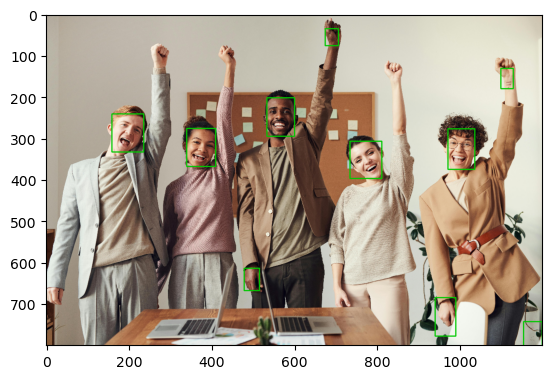

In [14]:
show_image = draw_faceboxes(image, face_boxes, scores)

plt.imshow(cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB))

In [15]:
cv2.imshow("Image", show_image)
cv2.waitKey()
cv2.destroyAllWindows()   